In [1]:
!pip install split-folders
!pip install tensorflow==2.4

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==2.4


In [2]:
# import required libraries
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D


In [3]:
from google.colab import drive # Mounting drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import splitfolders

input_folder = '/content/drive/MyDrive/Plant seedling Classification' # Folder where images of all classes stored
output_folder = '/content/dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2)) # splitted data train, val,test

Copying files: 5609 files [01:09, 81.26 files/s] 


In [5]:
import glob

train_length = 0
test_length = 0

for name in glob.glob('/content/dataset/train/*'):
  train_length += len(glob.glob(name+'/*.png'))

for name in glob.glob('/content/dataset/test/*'):
  test_length += len(glob.glob(name+'/*.png'))

print(train_length,test_length)

4481 1128


In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
data_dir_train = '/content/dataset/train' # path for train dataset
data_dir_test = '/content/dataset/test'

In [8]:
# creating train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4481 files belonging to 12 classes.
Using 3585 files for training.


In [9]:
# creating validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 4481 files belonging to 12 classes.
Using 896 files for validation.


In [10]:
# Listing out all the classes of plant seedlings and store them in a list (Folder names of each category are classes).

labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [11]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [12]:
count_plot  # Number of images of each class

[247, 361, 273, 570, 202, 432, 628, 205, 514, 219, 460, 370]

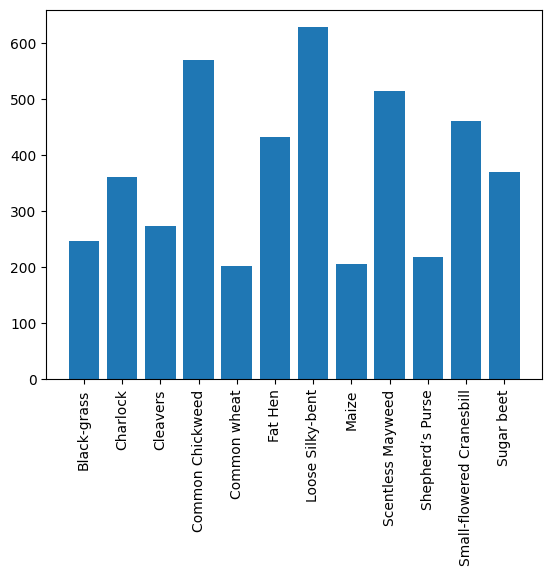

In [13]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

# ResNet 50 model

In [14]:
base_model = ResNet50(include_top=False, pooling='avg')

94765736/94765736 [==============================] - 2s 0us/step


In [15]:
input_shape = (224,224,3)
num_classes = 12

In [16]:
model = Sequential()
model.add(base_model)
model.add(Dense(num_classes, activation='softmax'))

In [17]:
base_model.trainable = False

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# spefying the format in which model needs to be saved
model_name = 'Seed' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [20]:
epochs = 200
batch_size = 32
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/200
113/113 [==============================] - ETA: 0s - loss: 1.2475 - accuracy: 0.6212
Epoch 1: val_loss improved from inf to 0.68456, saving model to Seed/model-00001-1.24749-0.68456-.h5
113/113 [==============================] - 55s 354ms/step - loss: 1.2475 - accuracy: 0.6212 - val_loss: 0.6846 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 2/200
112/113 [============================>.] - ETA: 0s - loss: 0.5519 - accuracy: 0.8479
Epoch 2: val_loss improved from 0.68456 to 0.49034, saving model to Seed/model-00002-0.55255-0.49034-.h5
113/113 [==============================] - 34s 290ms/step - loss: 0.5526 - accuracy: 0.8477 - val_loss: 0.4903 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 3/200
112/113 [============================>.] - ETA: 0s - loss: 0.4061 - accuracy: 0.8878
Epoch 3: val_loss improved from 0.49034 to 0.40141, saving model to Seed/model-00003-0.40604-0.40141-.h5
113/113 [==============================] - 33s 277ms/step - loss: 0.4060 - accuracy: 0.8879 - val_loss: 

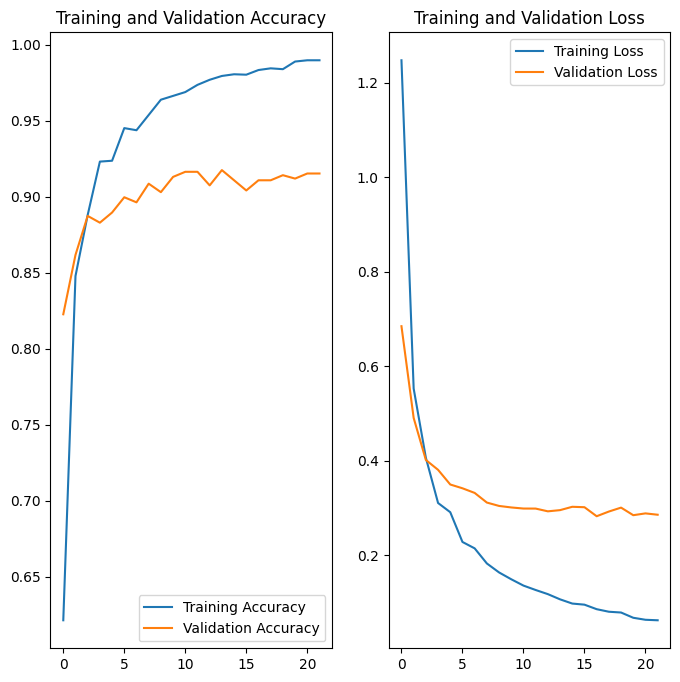

In [22]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**
1. Validation loss decreased to 0.2823.

2. Training accuracy is 98.33% and validation accuracy is 91%. Model is bit overfitted.

3. Learning became faster as pretrained weigts of imagenet dataset are used.



# Image augmentation

Using augmenter adding 500 synthetically generated images in each class.


In [23]:
### defining the path for training and test images
train_path = "/content/dataset/train/"
test_path = "/content/dataset/test/"

In [24]:
### distibution of classes for each category of data
### It can be seen that data has imbalances in the class distribution
for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 247 samples.
Charlock has 361 samples.
Cleavers has 273 samples.
Common Chickweed has 570 samples.
Common wheat has 202 samples.
Fat Hen has 432 samples.
Loose Silky-bent has 628 samples.
Maize has 205 samples.
Scentless Mayweed has 514 samples.
Shepherd’s Purse has 219 samples.
Small-flowered Cranesbill has 460 samples.
Sugar beet has 370 samples.


In [25]:
# You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes
# so that none of the classes have very few samples.
!pip install Augmentor

In [26]:
path_to_training_dataset=train_path

import Augmentor
for i in labels:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 247 image(s) found.
Output directory set to /content/dataset/train/Black-grass/output.

Processing <PIL.Image.Image image mode=RGB size=352x352 at 0x78102C107970>: 100%|██████████| 500/500 [02:51<00:00,  2.92 Samples/s]


Initialised with 361 image(s) found.
Output directory set to /content/dataset/train/Charlock/output.

Processing <PIL.Image.Image image mode=RGB size=910x910 at 0x781026F378E0>: 100%|██████████| 500/500 [00:59<00:00,  8.46 Samples/s]


Initialised with 273 image(s) found.
Output directory set to /content/dataset/train/Cleavers/output.

Processing <PIL.Image.Image image mode=RGB size=211x211 at 0x78102C05B730>: 100%|██████████| 500/500 [00:28<00:00, 17.74 Samples/s]


Initialised with 570 image(s) found.
Output directory set to /content/dataset/train/Common Chickweed/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=119x119 at 0x781026F5BEB0>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 202 image(s) found.
Output directory set to /content/dataset/train/Common wheat/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=745x745 at 0x781026F35A80>: 100%|██████████| 500/500 [01:05<00:00,  7.60 Samples/s]


Initialised with 432 image(s) found.
Output directory set to /content/dataset/train/Fat Hen/output.

Processing <PIL.Image.Image image mode=RGB size=414x414 at 0x78102C0779D0>: 100%|██████████| 500/500 [00:38<00:00, 13.11 Samples/s]


Initialised with 628 image(s) found.
Output directory set to /content/dataset/train/Loose Silky-bent/output.

Processing <PIL.Image.Image image mode=RGB size=111x111 at 0x7810362F0E80>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 205 image(s) found.
Output directory set to /content/dataset/train/Maize/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=751x751 at 0x7810361FBC40>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


Initialised with 514 image(s) found.
Output directory set to /content/dataset/train/Scentless Mayweed/output.

Processing <PIL.Image.Image image mode=RGB size=587x587 at 0x781075B75990>: 100%|██████████| 500/500 [00:30<00:00, 16.66 Samples/s]


Initialised with 219 image(s) found.
Output directory set to /content/dataset/train/Shepherd’s Purse/output.

Processing <PIL.Image.Image image mode=RGB size=139x139 at 0x781075BB5DB0>: 100%|██████████| 500/500 [00:32<00:00, 15.61 Samples/s]


Initialised with 460 image(s) found.
Output directory set to /content/dataset/train/Small-flowered Cranesbill/output.

Processing <PIL.Image.Image image mode=RGB size=552x552 at 0x78102C0D7940>: 100%|██████████| 500/500 [00:37<00:00, 13.17 Samples/s]


Initialised with 370 image(s) found.
Output directory set to /content/dataset/train/Sugar beet/output.

Processing <PIL.Image.Image image mode=RGB size=456x456 at 0x78102C05BAF0>: 100%|██████████| 500/500 [01:44<00:00,  4.80 Samples/s]


In [27]:
### Distribution of classes after augmentation
for i in labels:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

Black-grass has 747 samples.
Charlock has 861 samples.
Cleavers has 773 samples.
Common Chickweed has 1070 samples.
Common wheat has 702 samples.
Fat Hen has 932 samples.
Loose Silky-bent has 1128 samples.
Maize has 705 samples.
Scentless Mayweed has 1014 samples.
Shepherd’s Purse has 719 samples.
Small-flowered Cranesbill has 960 samples.
Sugar beet has 870 samples.


In [28]:
batch_size = 32
img_height = 224
img_width = 224

In [29]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10481 files belonging to 12 classes.
Using 8385 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10481 files belonging to 12 classes.
Using 2096 files for validation.


**Model**

In [44]:
base_model = ResNet50(include_top=False, pooling='avg')

In [45]:
input_shape = (224,224,3)
num_classes = 12

In [46]:
model = Sequential()
model.add(base_model)
model.add(Dense(num_classes, activation='softmax'))

In [47]:
base_model.trainable = False

In [48]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# spefying the format in which model needs to be saved
model_name = 'Seed_aug' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=10, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [50]:
epochs = 200
batch_size = 32
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/200
262/263 [============================>.] - ETA: 0s - loss: 0.8661 - accuracy: 0.7351
Epoch 1: val_loss improved from inf to 0.46271, saving model to Seed_aug/model-00001-0.86618-0.46271-.h5
263/263 [==============================] - 100s 357ms/step - loss: 0.8662 - accuracy: 0.7350 - val_loss: 0.4627 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 2/200
262/263 [============================>.] - ETA: 0s - loss: 0.3555 - accuracy: 0.8990
Epoch 2: val_loss improved from 0.46271 to 0.35440, saving model to Seed_aug/model-00002-0.35544-0.35440-.h5
263/263 [==============================] - 92s 342ms/step - loss: 0.3554 - accuracy: 0.8990 - val_loss: 0.3544 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 3/200
262/263 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9300
Epoch 3: val_loss improved from 0.35440 to 0.27689, saving model to Seed_aug/model-00003-0.25100-0.27689-.h5
263/263 [==============================] - 89s 332ms/step - loss: 0.2510 - accuracy: 0.9300

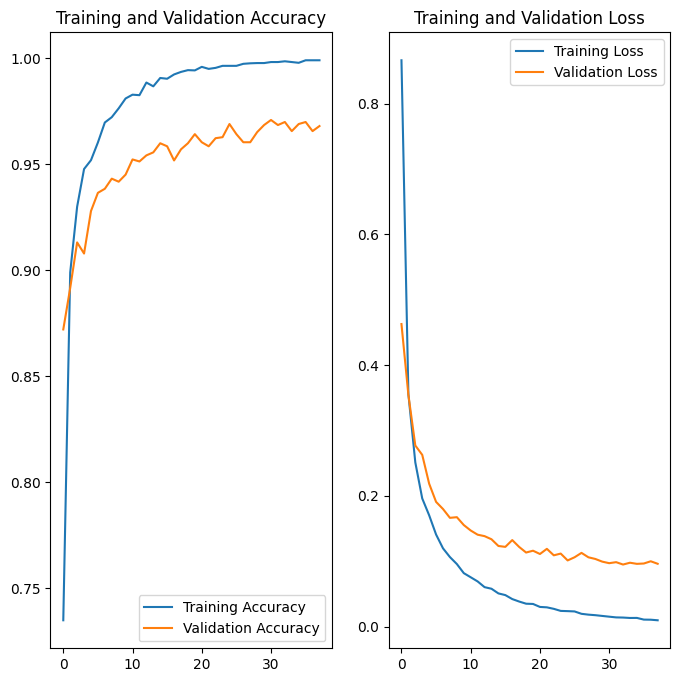

In [51]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(38)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

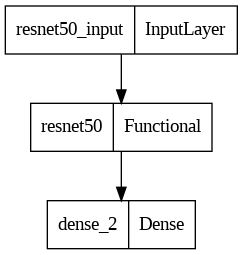

In [52]:
from keras.utils import plot_model

plot_model(model, to_file='ResNet50_model.png')

# Observations:
1. Achieved training accuracy= 99.__% and validation accuracy= 96.__%.

2. Validation loss is decreased drastically from 0.___ to 0.___.

3. Model is less overfitted compared to previous model due to use of augmentor.